In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import jaxopt
except ImportError:
    %pip install -q jaxopt

(classification)=

## GP Classification

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import numpyro
import numpyro.distributions as dist

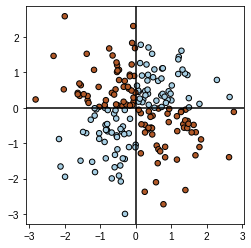

In [4]:
X = jax.random.normal(jax.random.PRNGKey(1234), (200, 2))
y = jnp.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(
    X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0)
)
plt.gca().set_aspect("equal")
_ = plt.axhline(0, color="k")
_ = plt.axvline(0, color="k")

In [5]:
xs = jnp.linspace(-2, 2, num=100)
ys = jnp.linspace(-2, 2, num=100)

xx, yy = jnp.meshgrid(xs, ys)
xx = xx.T
yy = yy.T
T = jnp.vstack((xx.ravel(), yy.ravel())).T

In [6]:
def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

In [7]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
import numpyro
import numpyro.distributions as dist
from tinygp import kernels, transforms, GaussianProcess


def model(x, y = None):
    # Set up a typical Squared Exponential kernel
    mean = numpyro.param("mean", jnp.zeros(()))
    sigma = numpyro.param("sigma", jnp.ones(()))
    ell = numpyro.param("ell", jnp.ones(()))

    kernel = (sigma ** 2) * kernels.ExpSquared(scale = ell)

    # Evaluate and return the GP negative log likelihood as usual
    gp = GaussianProcess(kernel, x, diag=1e-5, mean = mean)

    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    l = sigmoid(log_rate)
    numpyro.sample("obs", dist.Bernoulli(l), obs = y)


def guide(x, y=None):
    mu = numpyro.param(
        "log_rate_mu", jnp.zeros_like(x) if y is None else y.astype(float) + 1
    )
    sigma = numpyro.param(
        "log_rate_sigma",
        jnp.ones_like(y),
    )
    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))

In [9]:
optim = numpyro.optim.Adam(0.001)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(55873), 9000, X, y=y, progress_bar=False)

TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got bool. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.

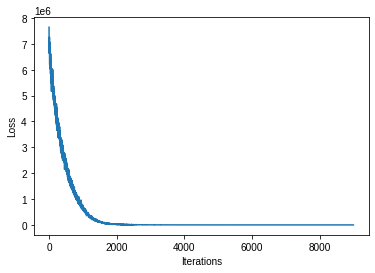

In [17]:
fig = plt.figure()
plt.plot(results.losses)
plt.xlabel("Iterations")
_ = plt.ylabel("Loss")

In [23]:
sigmoid(results.params["log_rate_mu"]) > 0.5

DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True, 

In [18]:
mean, var = results.params["log_rate_mu"], results.params["log_rate_sigma"]
y_hat = sigmoid(mean) > 0.5

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")


Accuracy: 50.50%


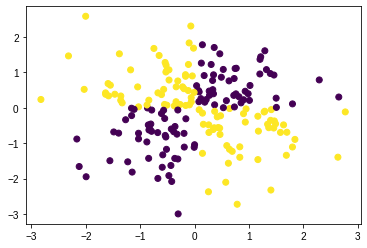

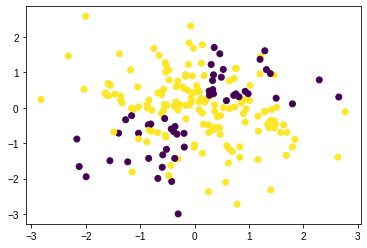

In [14]:
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y_hat)


In [15]:
xs = jnp.linspace(-2, 2, num=100)
ys = jnp.linspace(-2, 2, num=100)

# In newer version we should uncomment the following line
# xx, yy = jnp.meshgrid(xs, ys, indexing="xy")

xx, yy = jnp.meshgrid(xs, ys)
xx = xx.T
yy = yy.T


In [16]:
mean, var = model(jax.random.PRNGKey(873), jnp.vstack((xx.ravel(), yy.ravel())).T)
Z = numpyro.sample("y_hat", dist.Bernoulli(sigmoid(mean)), rng_key = jax.random.PRNGKey(873))

AssertionError: 

In [ ]:
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            sigmoid(mean).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
plot_pred_2d(mean.reshape(xx.shape), xx, yy, ax=ax[0], title="f")
plot_pred_2d(
    sigmoid(mean).reshape(xx.shape),
    xx,
    yy,
    ax=ax[1],
    title="p(y=1|f) = Sigmoid(f)",
    contour=True,
)
plot_pred_2d(T, xx, yy, ax=ax[2], title="Predictions (y) ~ Bernoulli(p(y=1|f))")

fig.tight_layout()